In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [10]:
mainDir = 'test2/'
X = sorted(glob(mainDir + 'images/*.tif'))

names = []
for name in X:
    names.append(name[name.rfind("\\")+1:])
    print(name[name.rfind("\\")+1:])
X = list(map(imread,X))
print(X)

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

01_w2Spinning - DAPI-1.tif
02_w2Spinning - DAPI-1.tif
03_w2Spinning - DAPI-1.tif
04_w2Spinning - DAPI-1.tif
05_w2Spinning - DAPI-1.tif
[array([[[100,  99,  98, ...,  99,  99,  98],
        [100,  99,  98, ...,  99,  99,  98],
        [ 98,  99,  99, ..., 100,  99,  98],
        ...,
        [100,  98, 100, ...,  98, 100,  99],
        [ 96,  98,  99, ...,  99,  99,  99],
        [ 98,  96,  98, ...,  98,  99,  99]],

       [[ 98,  99, 101, ..., 100, 100, 100],
        [ 98, 101, 102, ...,  99, 100,  99],
        [ 99, 100, 100, ...,  99,  99,  99],
        ...,
        [ 98,  97,  98, ...,  99,  98,  98],
        [ 98,  98,  98, ...,  99,  97,  97],
        [ 96,  98,  99, ...,  99,  99,  97]],

       [[ 99,  99, 100, ...,  98,  98,  98],
        [ 98,  99, 100, ...,  99,  99,  97],
        [ 99,  99,  99, ...,  98,  99,  96],
        ...,
        [ 98,  99,  98, ...,  99, 100,  99],
        [ 96,  97,  98, ...,  99,  99,  99],
        [ 95,  96,  97, ...,  98,  97,  98]],

       ..

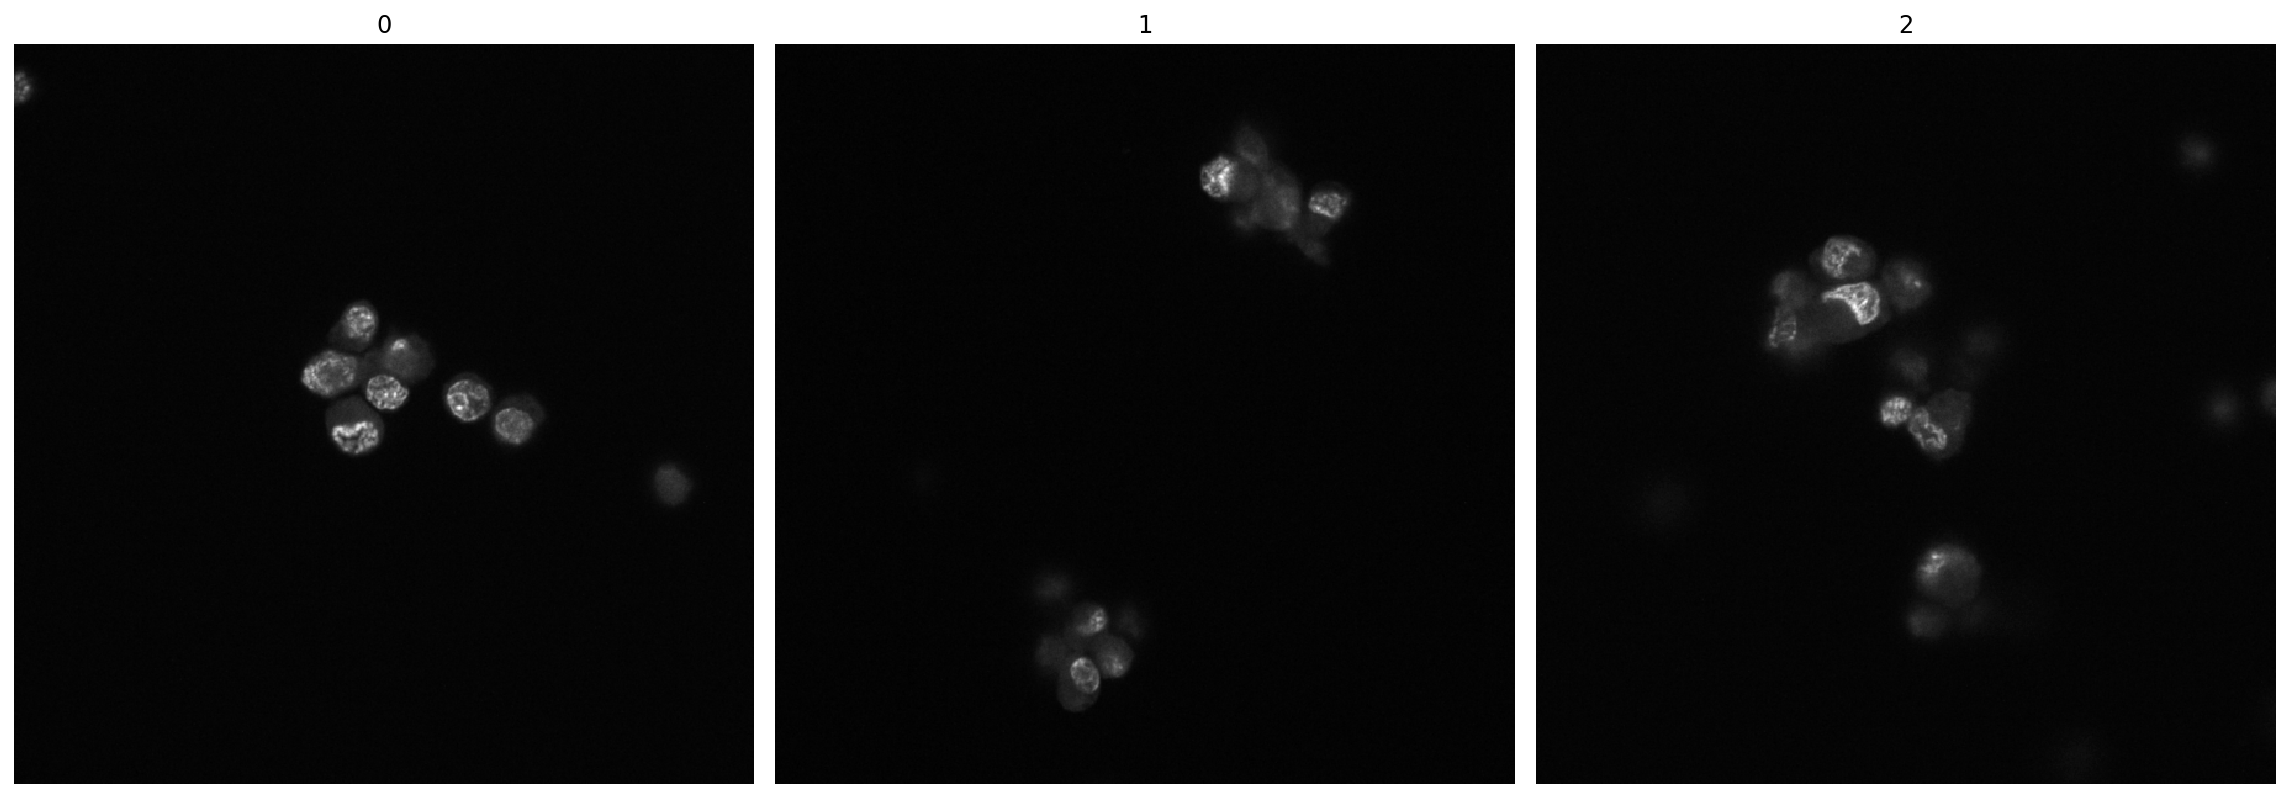

In [11]:
# show all test images
if True:
    fig, ax = plt.subplots(1,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [12]:
demo_model = False

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model = StarDist3D(None, name='stardist', basedir='models')
None;

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.280687, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [13]:
img = normalize(X[0], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

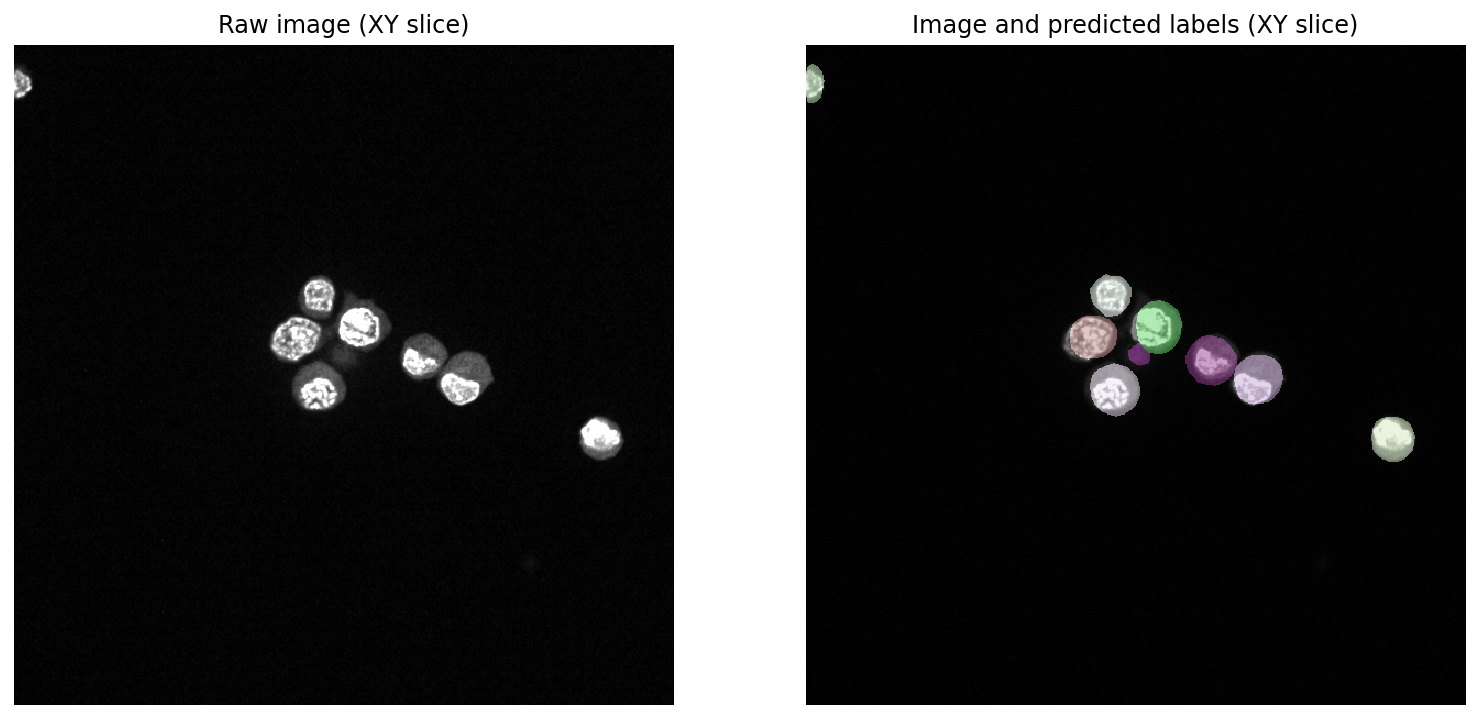

In [14]:
plt.figure(figsize=(13,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predicted label image to disk.

In [15]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='ZYX')
# save_tiff_imagej_compatible('example_labels.tif', labels, axes='ZYX')
for cur, name in zip(X, names):
    img = normalize(cur, 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)
    title = mainDir + "masks/" + name
    print(title)
    save_tiff_imagej_compatible(title, labels, axes='ZYX')

test2/masks/01_w2Spinning - DAPI-1.tif
test2/masks/02_w2Spinning - DAPI-1.tif
test2/masks/03_w2Spinning - DAPI-1.tif
test2/masks/04_w2Spinning - DAPI-1.tif
test2/masks/05_w2Spinning - DAPI-1.tif


# Example results

In [16]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,8))
    z = img.shape[0] // 2
    y = img.shape[1] // 2
    img_show = img if img.ndim==3 else img[...,:3]    
    plt.subplot(221); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.subplot(222); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.subplot(223); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
    plt.subplot(224); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.imshow(labels[:,y], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

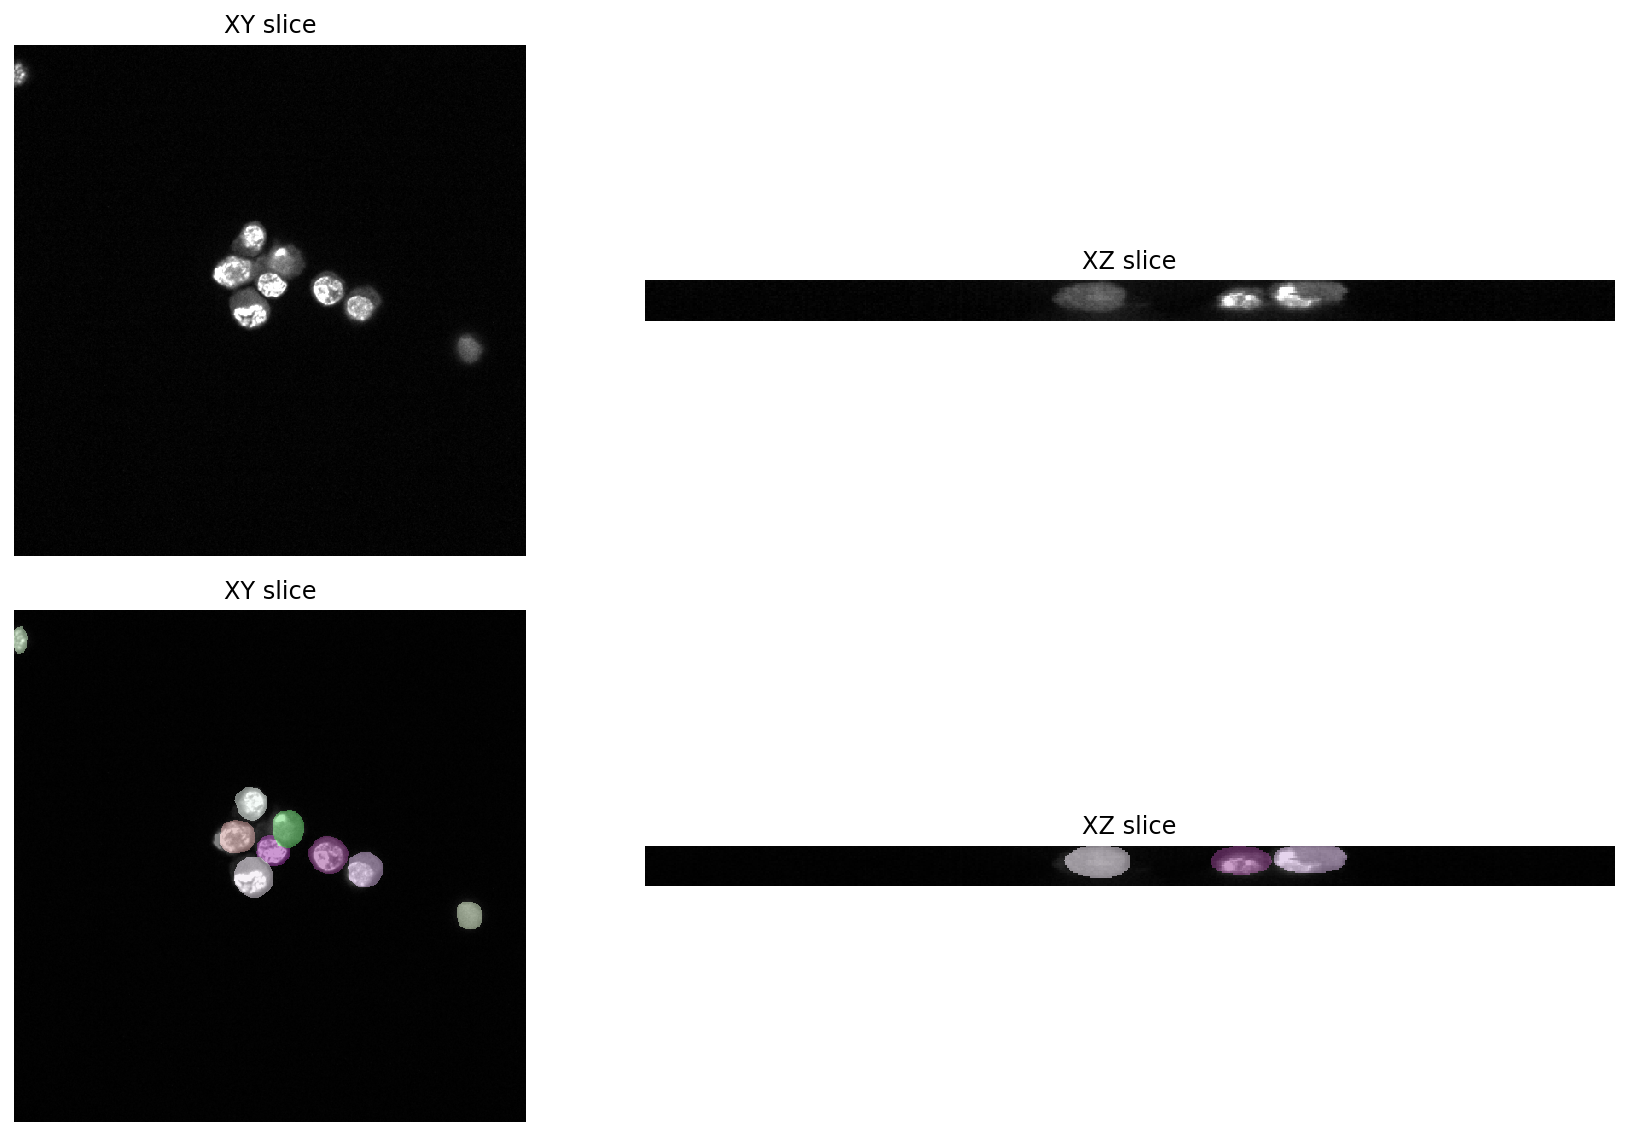

In [17]:
example(model, 0)

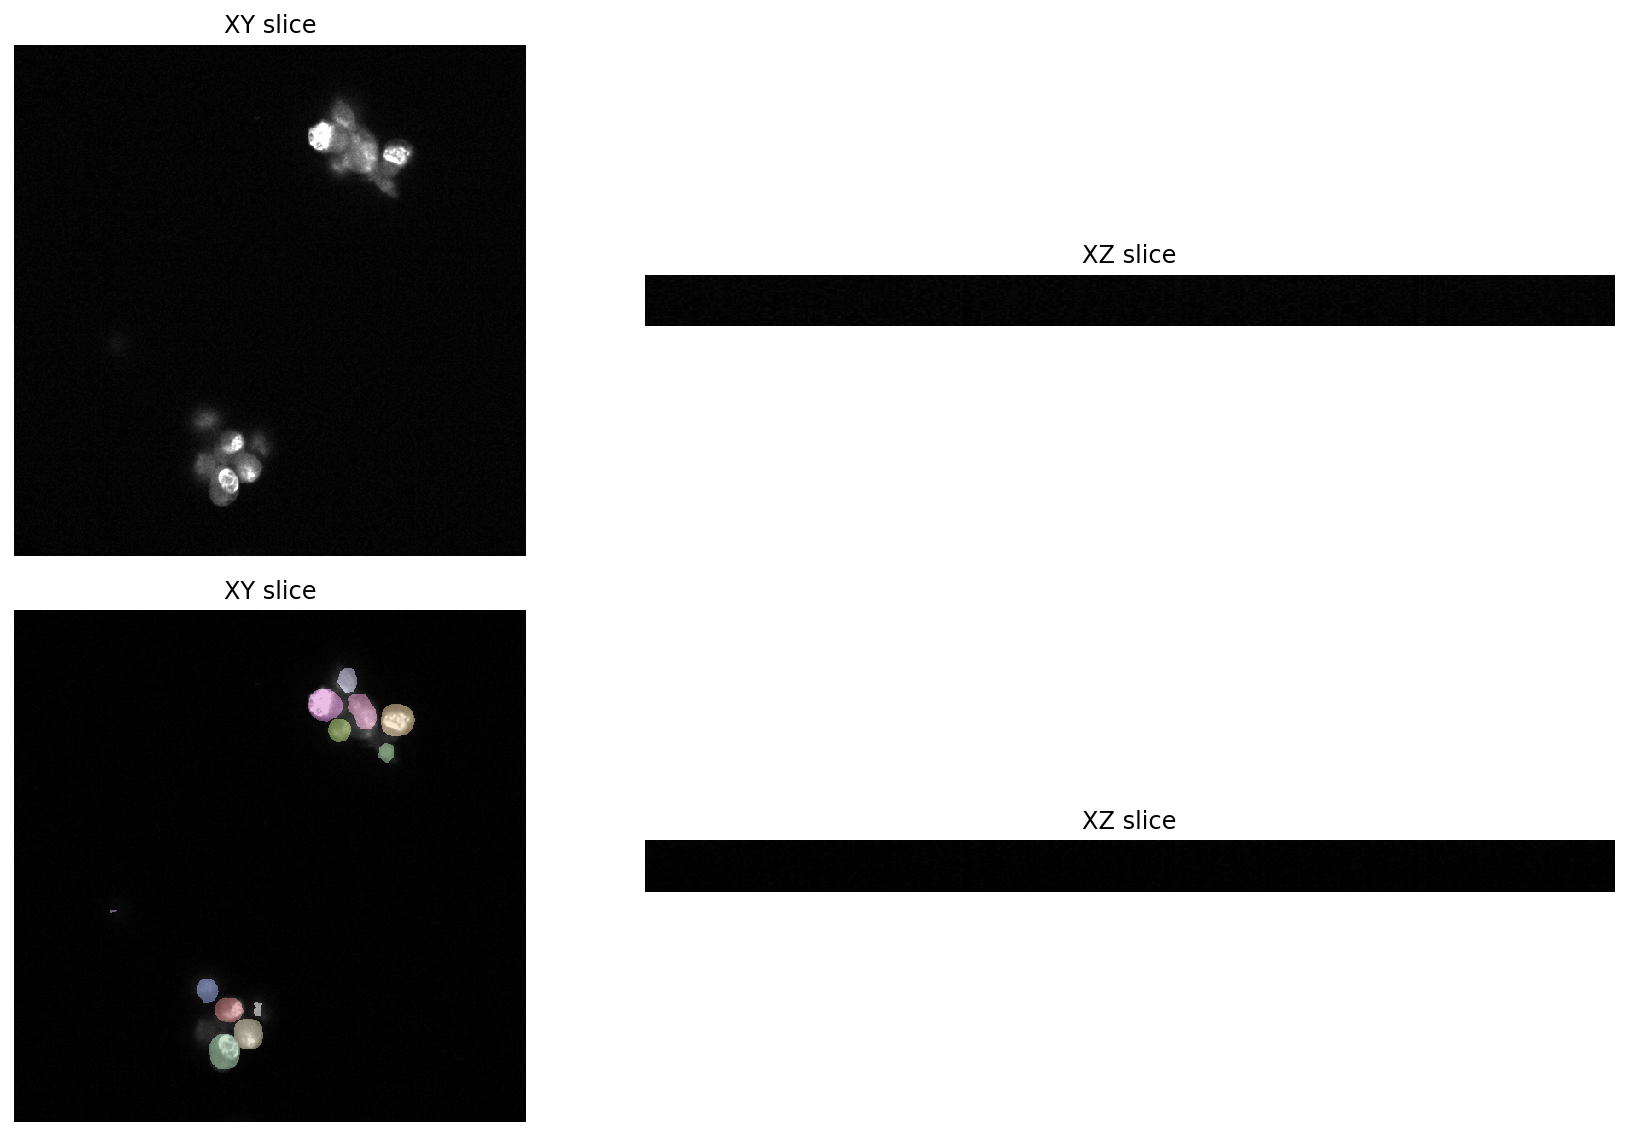

In [18]:
example(model, 1)

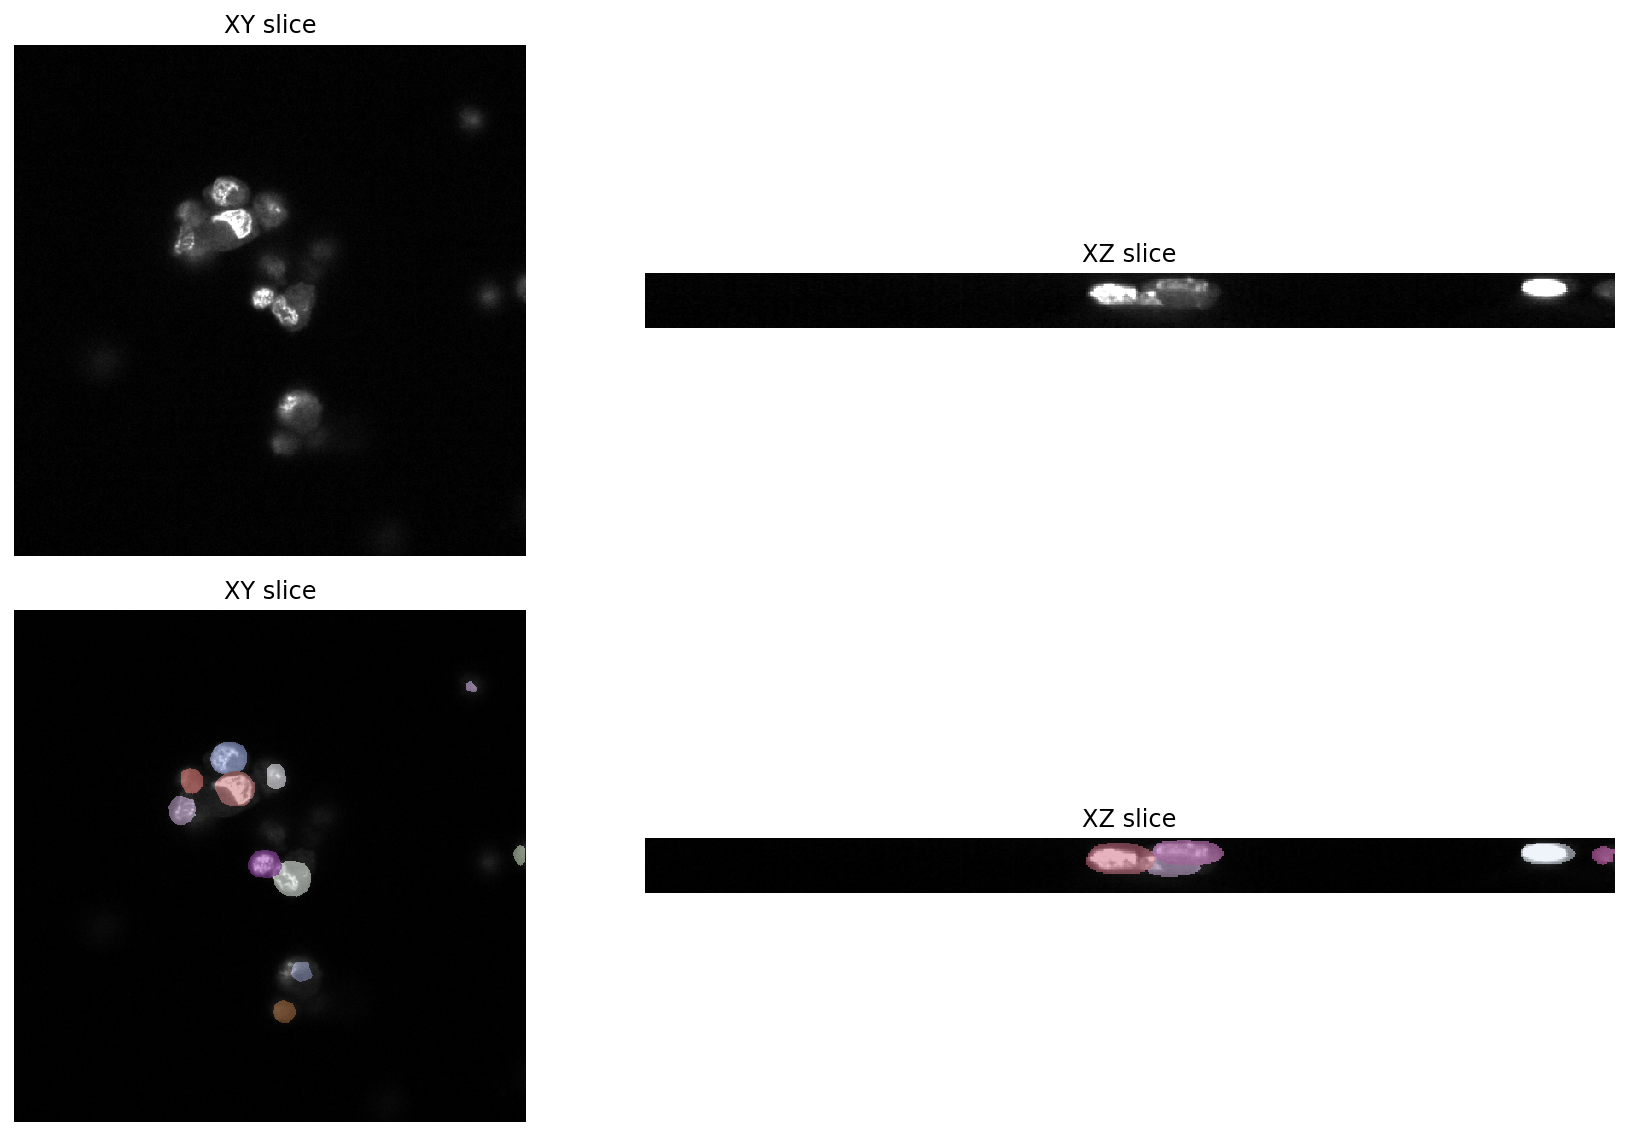

In [19]:
example(model, 2)